 <h1><center> Reflectometry Data Analysis and Simulation Software </center></h1>
 <h2><center> - Co-refinement of multiple contrast neutron reflectivity data in BornAgain - </center></h2>
<center>[The Lipid Bilayer model simulated in this notebook is based on the Refnx paper] </center>

Some of the essential and/or nice to have features of reflectometry software are:

 - Graphical User Interface
 - **Refine multiple datasets (multiple contrast co-refinement)**
 - Open source software 
 - Optimisation modules to find the best fit (global minimum)
 - Fitting  neutron and X-ray reflectometry data
 - Simple workflow

In this notebook, BornAgain is used to fit a model using multiple datasets (i.e. co-refinement). The model consist of a Lipid Bilayer on a Silicon Dioxide (${\rm SiO_2}$) bed; the whole immersed in a solvent and lying on top of a Silicon substrate. Three different solvents are used for co-refinement: water (${\rm H_2O}$), heavy water (${\rm D_2O}$) and a *contrast-match* mix of the two (${\rm HD_{mix}}$).

---

*Refnx paper: http://scripts.iucr.org/cgi-bin/paper?rg5158*   
*Bornagain: http://www.bornagainproject.org*  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from datetime import datetime as dtime
%matplotlib inline

In [2]:
import bornagain as ba
from bornagain import deg, angstrom
import LipidBilayerUtils as lip
WAVELENGTH = 1.0 # Dummy wavelength.
THETA_VALUES = np.linspace(0.0,10,1025)
Q_VALUES = 4.0*np.pi*np.sin(THETA_VALUES*np.pi/180.0)/WAVELENGTH
BornAgainLipidFile="./Lipid-BornAgain.dat"

### Helper Functions:

In [3]:
def theta_to_q(theta, wavelength = 1.0):
    return 4.0 * np.pi * np.sin(theta*np.pi/180.0) / wavelength

def q_to_theta(qvec, wavelength = 1.0):
    return 180.0 * np.arcsin( wavelength * qvec / (4.0*np.pi) ) / np.pi
                     
def ReflectometryInstrument():
    return ba.SpecularSimulation()

def create_ba_params(some_dict):
    ba_params = ba.Parameters()
    for k,v in some_dict.items():
        ba_params.add(k,v[0],min=v[1],max=v[2])
    return ba_params

def setup_instrument(parameters={}):
    wavelength = parameters["wavelength"] if "wavelength" in parameters else WAVELENGTH
    theta = parameters["theta"] if "theta" in parameters else THETA_VALUES
    background = parameters["background"] if "background" in parameters else 0.0
    
    instrument = ReflectometryInstrument()
    instrument.setBeamParameters(wavelength * angstrom, theta * deg)
    instrument.setBackground(ba.ConstantBackground(background))
    return instrument

def setup_sample(sample_parameters={}):
    xpar = lip.SampleParameters(sample_parameters)
    sample = lip.get_lipid_bilayer_sample(xpar)
    return sample

def instrument_with_sample(params):
    sample = setup_sample(params)
    instrument = setup_instrument(params)
    instrument.setSample(sample)
    return instrument
    
def ba_reflectivity(instrument,sample):
    instrument.setSample(sample)
    instrument.runSimulation()
    results = instrument.result()
    simulation_data = results.data()
    return simulation_data.getArray()

## Fitting wrapers to reduce boilerplate code:

In [4]:
def fit_single_model(model_to_fit, data_to_fit, dict_pars_to_fit):
    ba_params = create_ba_params(dict_pars_to_fit)
    fitter = lip.CustomFitObjective()
    fitter.addSimulationAndData(model_to_fit, data_to_fit)
    minimizer = ba.Minimizer()
    result = minimizer.minimize(fitter.evaluate, ba_params)
    fitter.finalize(result)
    fitted_params = result.parameters()
    fit_val_dict = {}
    fit_err_dict = {}
    for k in dict_pars_to_fit:
        fit_val_dict[k] = fitted_params[k].value
        fit_err_dict[k] = fitted_params[k].error
    return fit_val_dict, fit_err_dict

def fit_co_refinement(models_to_fit, data_to_fit, dict_pars_to_fit):
    ba_params = create_ba_params(dict_pars_to_fit)
    fitter = lip.CustomFitObjective()
    
    for model, data in zip(models_to_fit, data_to_fit):
        fitter.addSimulationAndData(model, data)
        
    minimizer = ba.Minimizer()
    result = minimizer.minimize(fitter.evaluate, ba_params)
    fitter.finalize(result)
    fitted_params = result.parameters()
    fit_val_dict = {}
    fit_err_dict = {}
    
    for par in fitted_params:
        fit_val_dict[par.name()] = par.value
        fit_err_dict[par.name()] = par.error
        
    return fit_val_dict, fit_err_dict

Inside `LipidBilayerUtils.py` the figure of merit is redefined:

  
```python 
   9 class CustomFitObjective(ba.FitObjective):
  10     def __init__(self):
  11         ba.FitObjective.__init__(self)
  12 
  13     def evaluate(self, params):
  14 
  15         # Evaluate residuals needs to be called always:
  16         bla = self.evaluate_residuals(params)
  17 
  18         sim = (np.asarray(self.simulation_array()))
  19         exp = (np.asarray(self.experimental_array()))
  20         eps = (np.sum(np.abs(exp))/exp.size) * 1e-14
  21         sim_exp_diff = ((sim - exp)/(eps + sim + exp))**2
  22 
  23         return sim_exp_diff.sum()
```

### Single Curve Fit in scipy:

```python
from scipy.optimize import curve_fit

def function_to_fit(x_data, a, b): 
    ...
    return y_model

popt, pcov = curve_fit(
    function_to_fit, 
    x_data, 
    y_data, 
    bounds = ([a_min,b_min],[a_max,b_max])
)
```

### Fitting using the wrappers:

In [5]:
refl_clean = ba_reflectivity(setup_instrument(),setup_sample())

dict_params = {'head_a_thickness' : (7.5,5,10), 'head_f_thickness' : (7.5,5,10)}

fit_val_dict, fit_err_dict = fit_single_model(instrument_with_sample, refl_clean, dict_params)

### Obtaining resulting model:

head_a_thickness =  9.815177643555847  +/-  0.05945901988541369 ; correct value :  9.815135921819564
head_f_thickness =  5.6481658113101165  +/-  0.029202189809369727 ; correct value :  5.648173678129387


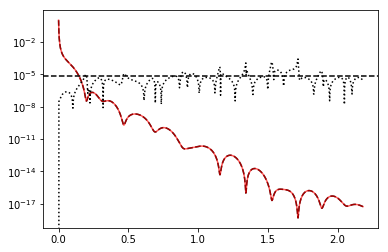

In [6]:
refl_fit = ba_reflectivity(setup_instrument(),setup_sample(fit_val_dict))

for k in fit_val_dict:
    print(k + " = ",fit_val_dict[k], " +/- ", fit_err_dict[k], "; correct value : ", lip.SampleParameters()[k])
    
sim = refl_fit
exp = refl_clean
relerr = 0.5*abs(sim-exp)/abs(sim+exp)
plt.plot(Q_VALUES,exp,'k--')
plt.plot(Q_VALUES,sim,'r-',alpha=0.65)
plt.plot(Q_VALUES,relerr,'k:')
plt.yscale('log')
plt.axhline(y=relerr.mean(),color='k',ls='--')

# Co-Refinement of simulated data

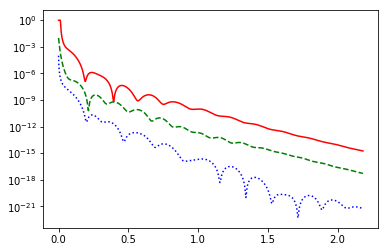

In [7]:
data_clean_d2o = ba_reflectivity(setup_instrument(),setup_sample({'solvent_sld' : lip.SampleParameters().d2o_sld}))
data_clean_h2o = ba_reflectivity(setup_instrument(),setup_sample({'solvent_sld' : lip.SampleParameters().h2o_sld}))
data_clean_hdmix = ba_reflectivity(setup_instrument(),setup_sample({'solvent_sld' : lip.SampleParameters().si_sld}))

plt.plot(Q_VALUES,data_clean_d2o,'r-')
plt.plot(Q_VALUES,1e-2*data_clean_h2o,'g--')
plt.plot(Q_VALUES,1e-4*data_clean_hdmix,'b:')
plt.yscale('log')

In [8]:
dict_pars_to_fit = {'head_a_thickness' : (7.5,5,10), 'head_f_thickness' : (7.5,5,10)}

model_to_fit_d2o   = lambda params : instrument_with_sample({**params,'solvent_sld' : lip.SampleParameters().d2o_sld})
model_to_fit_h2o   = lambda params : instrument_with_sample({**params,'solvent_sld' : lip.SampleParameters().h2o_sld})
model_to_fit_hdmix = lambda params : instrument_with_sample({**params,'solvent_sld' : lip.SampleParameters().si_sld})

models_to_fit = [model_to_fit_d2o,model_to_fit_h2o,model_to_fit_hdmix]
data_to_fit   = [data_clean_d2o,data_clean_h2o,data_clean_hdmix]

fit_val_dict, fit_err_dict = fit_co_refinement(models_to_fit, data_to_fit, dict_pars_to_fit)

refl_fit_d2o   = ba_reflectivity(setup_instrument(),setup_sample({**fit_val_dict,'solvent_sld' : lip.SampleParameters().d2o_sld}))
refl_fit_h2o   = ba_reflectivity(setup_instrument(),setup_sample({**fit_val_dict,'solvent_sld' : lip.SampleParameters().h2o_sld}))
refl_fit_hdmix = ba_reflectivity(setup_instrument(),setup_sample({**fit_val_dict,'solvent_sld' : lip.SampleParameters().si_sld}))

for k in fit_val_dict:
    print(k + " = ",fit_val_dict[k], " +/- ", fit_err_dict[k], "; correct value : ", lip.SampleParameters()[k])

head_a_thickness =  9.815067970152993  +/-  0.06450997784324652 ; correct value :  9.815135921819564
head_f_thickness =  5.64819730637171  +/-  0.035325557165189814 ; correct value :  5.648173678129387


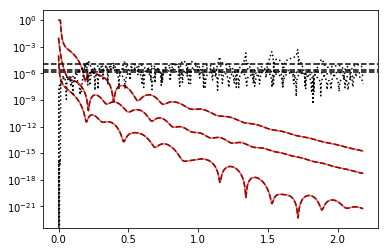

In [9]:
shift = 1.0
for exp, sim in zip([refl_fit_d2o,refl_fit_h2o, refl_fit_hdmix],[data_clean_d2o,data_clean_h2o, data_clean_hdmix]):
    relerr = 0.5*abs(sim-exp)/abs(sim+exp)
    plt.plot(Q_VALUES,shift*exp,'k--')
    plt.plot(Q_VALUES,shift*sim,'r-',alpha=0.65)
    plt.plot(Q_VALUES,relerr,'k:')
    plt.yscale('log')
    plt.axhline(y=relerr.mean(),color='k',ls='--')
    shift *= 0.01


# Co-refinement of actual data

### 1. Import data and filter out spurious data-points:

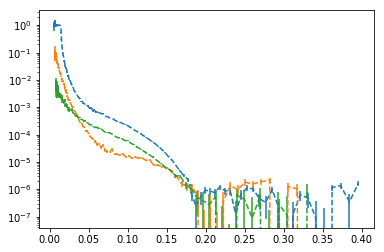

In [10]:
file_data_to_fit = lambda name : "../DataToFit/RefnxData_"+name+".dat"
#file_data_to_fit = lambda name : "../DataToFit/FitByRefnx_"+name+".txt"


real_data = {}
for solvent_name in ["d2o", "h2o", "hdmix"]:
    real_data[solvent_name] = lip.get_real_data(file_data_to_fit(solvent_name))
    plt.errorbar(real_data[solvent_name][:,0],real_data[solvent_name][:,1],yerr=real_data[solvent_name][:,2],ls='--')

plt.yscale('log')

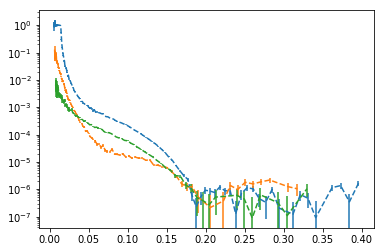

In [11]:
filtered_data = {}

for solvent_name in ["d2o", "h2o", "hdmix"]:
    filtered_data[solvent_name] =  real_data[solvent_name][(real_data[solvent_name][:,1]>0)]
    plt.errorbar(filtered_data[solvent_name][:,0],filtered_data[solvent_name][:,1],yerr=filtered_data[solvent_name][:,2],ls='--')
    
plt.yscale('log')

### 2. Define the models and the parameters to fit:

 - The models are defined as functions of a single argument --the parameters to fit:
 $$f(\{ {\rm p_i} \})$$
 - The parameters are defined as a python dictionary:
 $$\{ {\rm p_i} : {\rm (v_{i,0}, v_{i,min}, v_{i,max}) } \}$$

In [12]:
instrument_params = lambda name : {"theta" : q_to_theta(filtered_data[name][:,0]), 
                                   "background": lip.SampleParameters()[name+"_bkg"]
                                  }

model_to_fit_d2o   = lambda params : instrument_with_sample({
        **params,
        'solvent_sld' : lip.SampleParameters().d2o_sld,
        **instrument_params('d2o')
    })

model_to_fit_h2o   = lambda params : instrument_with_sample({
        **params,
        'solvent_sld' : lip.SampleParameters().h2o_sld,
        **instrument_params('h2o')
    })
    
model_to_fit_hdmix = lambda params : instrument_with_sample({
        **params,
        'solvent_sld' : lip.SampleParameters().si_sld,
        **instrument_params('hdmix')
    })

dict_pars_to_fit = {'head_a_thickness' : (7.5,5,10), 'head_f_thickness' : (7.5,5,10)}
models_to_fit = [model_to_fit_d2o, model_to_fit_h2o, model_to_fit_hdmix]
data_to_fit   = [filtered_data[solvent_name][:,1] for solvent_name in ["d2o", "h2o", "hdmix"]]

## The fitting happens here:

In [13]:
fit_val_dict, fit_err_dict = fit_co_refinement(models_to_fit, data_to_fit, dict_pars_to_fit)

## Create and plot models with the fitted parameters:

head_a_thickness =  9.999999858570444  +/-  3.7585426898968235 ; correct value :  9.815135921819564
head_f_thickness =  5.53744363744561  +/-  1.291835172884666 ; correct value :  5.648173678129387


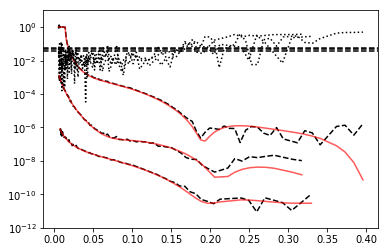

In [14]:
for k in fit_val_dict:
    print(k + " = ",fit_val_dict[k], " +/- ", fit_err_dict[k], "; correct value : ", lip.SampleParameters()[k])

refl_fit ={}
refl_fit['d2o']   = ba_reflectivity(setup_instrument(instrument_params("d2o")),setup_sample({**fit_val_dict,'solvent_sld' : lip.SampleParameters()['d2o_sld']}))
refl_fit['h2o']   = ba_reflectivity(setup_instrument(instrument_params("h2o")),setup_sample({**fit_val_dict,'solvent_sld' : lip.SampleParameters()['h2o_sld']}))
refl_fit['hdmix'] = ba_reflectivity(setup_instrument(instrument_params("hdmix")),setup_sample({**fit_val_dict,'solvent_sld' : lip.SampleParameters()['si_sld']}))

shift = 1.0
accum = 0.0
for solvent_name in ["d2o", "h2o", "hdmix"]:
    qvals = filtered_data[solvent_name][:,0]
    exp = filtered_data[solvent_name][:,1]
    sim = refl_fit[solvent_name]
    relerr = 0.5*(abs(sim-exp)/abs(sim+exp))
    plt.plot(qvals,shift*exp,'k--')
    plt.plot(qvals,shift*sim,'r-',alpha=0.65)
    plt.plot(qvals,relerr,'k:')
    plt.yscale('log')
    plt.axhline(y=relerr.mean(),color='k',ls='--')
    plt.ylim([1e-12,1e1])
    shift *= 0.01

## Do the same for the benchmark *model* (The model fitted by Refnx):

head_a_thickness =  9.607621059085549  +/-  3.7325594317799986 ; correct value :  9.815135921819564
head_f_thickness =  5.609183137715867  +/-  0.9106375281659838 ; correct value :  5.648173678129387


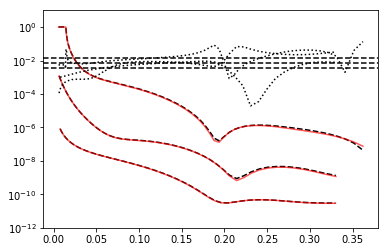

In [15]:
file_data_to_fit = lambda name : "../DataToFit/FitByRefnx_"+name+".txt"


real_data = {}
filtered_data = {}
for solvent_name in ["d2o", "h2o", "hdmix"]:
    real_data[solvent_name] = lip.get_real_data(file_data_to_fit(solvent_name))
    filtered_data[solvent_name] =  real_data[solvent_name][(real_data[solvent_name][:,1]>0)]
data_to_fit   = [filtered_data[solvent_name][:,1] for solvent_name in ["d2o", "h2o", "hdmix"]]

fit_val_dict, fit_err_dict = fit_co_refinement(models_to_fit, data_to_fit, dict_pars_to_fit)

for k in fit_val_dict:
    print(k + " = ",fit_val_dict[k], " +/- ", fit_err_dict[k], "; correct value : ", lip.SampleParameters()[k])

refl_fit ={}
refl_fit['d2o']   = ba_reflectivity(setup_instrument(instrument_params("d2o")),setup_sample({**fit_val_dict,'solvent_sld' : lip.SampleParameters()['d2o_sld']}))
refl_fit['h2o']   = ba_reflectivity(setup_instrument(instrument_params("h2o")),setup_sample({**fit_val_dict,'solvent_sld' : lip.SampleParameters()['h2o_sld']}))
refl_fit['hdmix'] = ba_reflectivity(setup_instrument(instrument_params("hdmix")),setup_sample({**fit_val_dict,'solvent_sld' : lip.SampleParameters()['si_sld']}))

shift = 1.0
accum = 0.0
for solvent_name in ["d2o", "h2o", "hdmix"]:
    qvals = filtered_data[solvent_name][:,0]
    exp = filtered_data[solvent_name][:,1]
    sim = refl_fit[solvent_name]
    relerr = 0.5*(abs(sim-exp)/abs(sim+exp))
    plt.plot(qvals,shift*exp,'k--')
    plt.plot(qvals,shift*sim,'r-',alpha=0.65)
    plt.plot(qvals,relerr,'k:')
    plt.yscale('log')
    plt.axhline(y=relerr.mean(),color='k',ls='--')
    plt.ylim([1e-12,1e1])
    shift *= 0.01
